# Решение

# напиши requires.txt (матплотлиб как минимум) 

## Подготовка
В процессе используются новые методы `matplotlib`, которые появились только в версии `3.4.4`

In [3]:
!pip3 install -U matplotlib

     |████████████████████████████████| 11.2 MB 9.5 MB/s 
     |████████████████████████████████| 895 kB 37.6 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
import os
os.kill(os.getpid(), 9)

## 1. Скачать файл по ссылке

In [1]:
!wget 'https://raw.githubusercontent.com/mwaskom/seaborn-data/master/titanic.csv' 'titanic.csv'

--2022-02-14 04:19:12--  https://raw.githubusercontent.com/mwaskom/seaborn-data/master/titanic.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 57018 (56K) [text/plain]
Saving to: ‘titanic.csv’

titanic.csv         100%[===================>]  55.68K  --.-KB/s    in 0.001s  

2022-02-14 04:19:12 (55.3 MB/s) - ‘titanic.csv’ saved [57018/57018]

--2022-02-14 04:19:12--  http://titanic.csv/
Resolving titanic.csv (titanic.csv)... failed: Name or service not known.
wget: unable to resolve host address ‘titanic.csv’
FINISHED --2022-02-14 04:19:12--
Total wall clock time: 0.05s
Downloaded: 1 files, 56K in 0.001s (55.3 MB/s)


## 2. Изучение данных

### Информация

In [1]:
import pandas as pd

df = pd.read_csv('/content/titanic.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   survived     891 non-null    int64  
 1   pclass       891 non-null    int64  
 2   sex          891 non-null    object 
 3   age          714 non-null    float64
 4   sibsp        891 non-null    int64  
 5   parch        891 non-null    int64  
 6   fare         891 non-null    float64
 7   embarked     889 non-null    object 
 8   class        891 non-null    object 
 9   who          891 non-null    object 
 10  adult_male   891 non-null    bool   
 11  deck         203 non-null    object 
 12  embark_town  889 non-null    object 
 13  alive        891 non-null    object 
 14  alone        891 non-null    bool   
dtypes: bool(2), float64(2), int64(4), object(7)
memory usage: 92.4+ KB


#### Определение переменных для дальнейшей работы

In [2]:
# columns
survived = 'survived'
pclass = 'pclass'
sex = 'sex'
age = 'age'
sibsp = 'sibsp'
parch = 'parch'
fare = 'fare'
embarked = 'embarked'
class_ = 'class'
who = 'who'
adult_male = 'adult_male'
deck = 'deck'
embark_town = 'embark_town'
alive = 'alive'
alone = 'alone'

# values
unknown = 'Unknown'
u = 'U'

### Пропуски
* возраст (`age`, 177 пропусков)
* порт посадки (`embarked`, 2 пропуска)
* палуба (`deck`, 688 пропусков)
* город посадки (`embark_town`, 2 пропуска)

### Заполнение пропусков
#### Возраст 
Принято решение написать небольшую модель,
обучить ее на заполненных данных
и предугадать примерный возраст в пропущенных ячейках.

#### Порт посадки 
Все пропуски = `U` (unknown).

#### Город посадки
Все пропуски = `Unknown`.

#### Палуба
Все пропуски = `U`.

#### Пропуски посадки

In [3]:
def fill_na_embark(data_frame: pd.DataFrame) -> pd.DataFrame:
    data_frame[embarked] = data_frame[embarked].fillna(u)
    data_frame[embark_town] = data_frame[embark_town].fillna(unknown)

    return data_frame

In [4]:
def for_print_embark(data_frame: pd.DataFrame, column_offset: int = 4) -> pd.DataFrame:
    """
    Функция для отображения информации 
    об уникальных значениях в столбцах 'embarked' и 'embark_town'
    """
    for_print = [('Порты:', 'Города:')]
    max_len_port = len(for_print[0][0])
    output_str = ''

    unique_ports, unique_towns = data_frame[embarked].unique(), data_frame[embark_town].unique()
    
    for index in range(max(len(unique_ports), len(unique_towns))):
        temp_port = unique_ports[index] if index < len(unique_ports) else ''
        temp_town = unique_towns[index] if index < len(unique_towns) else ''

        max_len_port = max(max_len_port, len(temp_port))

        for_print.append((temp_port, temp_town))

    for port, town in for_print: 
        output_str += f'{port}{" " * (max_len_port + column_offset - len(port))}{town}\n'

    return output_str

In [5]:
df = fill_na_embark(df)
print(for_print_embark(df))

Порты:    Города:
S         Southampton
C         Cherbourg
Q         Queenstown
U         Unknown



#### Пропуски возраста

##### Подготовка данных

In [6]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.losses import mse
from tensorflow.keras.metrics import mae
from tensorflow.keras.activations import relu, sigmoid

from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

from typing import Iterable

In [7]:
def prepare_data(data_frame): 
    data_frame_copy = data_frame.copy()
    data_frame_copy[pclass] = data_frame_copy[pclass].apply(lambda text_pclass: P_CLASSES[text_pclass])
    data_frame_copy[sex] = data_frame_copy[sex].apply(lambda text_sex: int(text_sex == 'female'))
    data_frame_copy[fare] *= FARE_NORMALIZER
    data_frame_copy[sibsp] *= SIBSP_NORMALIZER
    data_frame_copy[parch] *= PARCH_NORMALIZER
    data_frame_copy[class_] = data_frame_copy[class_].apply(lambda text_class: CLASSES[text_class])
    data_frame_copy[alive] = data_frame_copy[alive].apply(lambda text_alive: int(text_alive == 'yes'))
    data_frame_copy[alone] = data_frame_copy[alone].apply(int)

    data_frame_copy[age] *= AGE_NORMALIZER

    return data_frame_copy

In [8]:
X_COLUMNS = [pclass, sex, sibsp, parch, fare, class_, alive, alone]
Y_COLUMNS = [age]
AGE_NORMALIZER = 0.01
FARE_NORMALIZER = 0.001
SIBSP_NORMALIZER = 0.1
PARCH_NORMALIZER = 0.1
CLASSES = {'First': 0.1, 'Second': 0.5, 'Third': 0.9}
P_CLASSES = {1: 0.1, 2: 0.5, 3: 0.9}

data = df[df.loc[:, age].notna()]
prepared_data = prepare_data(data)
x_data, y_data = prepared_data[X_COLUMNS].to_numpy(), prepared_data[Y_COLUMNS].to_numpy()
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, train_size=0.9)

##### Аугментация данных

In [ ]:
RANDOM_NUMBER_VARIANT = 1
RANDOM_CHOICE_VARIANT = 2


def data_augmentation(x: np.array, y: np.array, count: int = 1, x_transformations: Iterable = tuple()):
    """
    Функция для аугментации данных. !Возвращает только новые данные
    x: входные данные
    y: выходные данные
    count: количество новых данных
    x_transformations: список с инструкциями для преобразований,
        где инструкции могут быть двух видов:
        1. {
            't_variant': 1       вид инструкции, 1 - выбор случайного числа из диапазона
            'index': int         индекс столбца, нод которым надо произвести данную инструкцию
            'min': float         минимальное возможное значение столбца
            'max': float         максимальное возможное значение для столбца
            'max_plus': float    какое максимальное отклонение в большую сторону
                                 может быть для значения x,
                                 то есть задает диапазон [x, x + max_plus] для нового значения
            'max_minus': float   аналогично 'max_plus', но задает [x - max_minus, x]
                                 * 'max_minus' и 'max_plus' задают границы для определенного значения x,
                                 * а 'max' и 'min' задают глобальные границы, за которые невозможно выйти ни одному x
            'round': int         до какого знака после запятой нужно округлить
        }
        2. {
            't_variant': 2      вид инструкции, 2 - выбор из набора вариантов
            'index': int
            'choice': list      массив из вариантов новых значений. если x нет в массиве, он не меняется
            'max_plus': int     на сколько индексов можно уйти в правую сторону от значения x,
                                необходимо для отсортированных массивов, к примеру когда есть несколько классов
                                и изменять данные нужно только переходом в соседние классы
            'max_minus': int    аналогично 'max_plus', только в левую сторону
                                * для того, чтобы выбор был из всего массива,
                                * 'max_plus' и 'max_minus' следует установить такими,
                                * чтобы они были больше длины массива 'choice'
        }
    """
    new_x, new_y = [0] * count, [0] * count
    for new_index in range(count):
        # выбираем случайный элемент из массива
        old_index = np.random.choice(len(x), 1)
        new_x_elem = np.array(x[old_index], copy=True)[0]

        # применяем изменения
        for transform in x_transformations:
            if transform['t_variant'] == RANDOM_NUMBER_VARIANT:
                minimum = max(transform['min'], new_x_elem[transform['index']] - transform['max_minus'])
                maximum = min(transform['max'], new_x_elem[transform['index']] + transform['max_plus'])
                new_value = np.random.uniform(minimum, maximum)
                new_x_elem[transform['index']] = round(new_value, transform['round'])

            elif transform['t_variant'] == RANDOM_CHOICE_VARIANT:
                # если нет элемента в массиве с новыми выборами, пропускаем
                if new_x_elem[transform['index']] not in transform['choice']:
                    continue

                index_before_transformation = transform['choice'].index(new_x_elem[transform['index']])
                minimum_index = max(0, index_before_transformation - transform['max_minus'])
                maximum_index = min(len(transform['choice']),
                                    index_before_transformation + transform['max_plus'] + 1)

                choice_from = transform['choice'][minimum_index:maximum_index]
                new_value = np.random.choice(choice_from)
                new_x_elem[transform['index']] = new_value
                
        new_x[new_index] = new_x_elem
        new_y[new_index] = y[old_index]
    return np.array(new_x), np.array(new_y)[:, 0]  # в y создается лишняя размерность, убираем ее


In [ ]:
new_x_train, new_y_train = data_augmentation(
    x_train, y_train, count=300,
    x_transformations=[
        {  # sibsp
            'index': 2,
            't_variant': RANDOM_CHOICE_VARIANT,
            'choice': [0.1 * i for i in range(8)],
            'max_plus': 1,
            'max_minus': 1,
        },
        {  # parch
            'index': 3,
            't_variant': RANDOM_CHOICE_VARIANT,
            'choice': [0.1 * i for i in range(8)],
            'max_plus': 0,
            'max_minus': 1,
        },
        {  # fare
            'index': 4,
            't_variant': RANDOM_NUMBER_VARIANT,
            'min': 0,
            'max': 1,
            'max_plus': 0.010,
            'max_minus': 0.010,
            'round': 7
        }
    ])


In [ ]:
total_x_train, total_y_train = (
    np.concatenate((x_train, new_x_train)), 
    np.concatenate((y_train, new_y_train))
)

In [ ]:
print(f'Всего данных для обучения{total_x_train.shape}')

Всего данных для обучения(942, 8)


##### Создание и обучение модели

In [ ]:
def create_model():
    input_layer = Input(len(X_COLUMNS))
    layers_values = ((16, relu), 
                     (256, relu), 
                     (512, relu),
                     (768, relu),
                     (768, relu),
                     (768, relu),
                     (1024, relu),
                     (4096, relu),
                     (4096, relu),
                     (1024, relu),
                     (512, relu),
                     (256, relu),
                     (128, relu),
                     (128, relu), 
                     (56, relu), 
                     (len(Y_COLUMNS), sigmoid))
    last_layer = Dense(layers_values[0][0], layers_values[0][1])(input_layer)
    for units, activation in layers_values[1:]:
        last_layer = Dense(units, activation)(last_layer)

    return Model(input_layer, last_layer)

In [ ]:
model = create_model()
model.compile(optimizer=Adam(), loss=mse, metrics=[mae])

In [ ]:
BATCH_SIZE = 4
EPOCHS = 600
history = model.fit(total_x_train, total_y_train, batch_size=BATCH_SIZE, epochs=EPOCHS).history
# убрал длинный вывод данных, оставил только 5 первых и последних эпох

Epoch 1/600
236/236 [==============================] - 7s 22ms/step - loss: 0.0225 - mean_absolute_error: 0.1193
Epoch 2/600
236/236 [==============================] - 5s 22ms/step - loss: 0.0193 - mean_absolute_error: 0.1116
Epoch 3/600
236/236 [==============================] - 6s 24ms/step - loss: 0.0184 - mean_absolute_error: 0.1087
Epoch 4/600
236/236 [==============================] - 6s 26ms/step - loss: 0.0189 - mean_absolute_error: 0.1098
Epoch 5/600
236/236 [==============================] - 4s 17ms/step - loss: 0.0175 - mean_absolute_error: 0.1061
...
Epoch 595/600
236/236 [==============================] - 4s 18ms/step - loss: 0.0105 - mean_absolute_error: 0.0781
Epoch 596/600
236/236 [==============================] - 4s 18ms/step - loss: 0.0106 - mean_absolute_error: 0.0784
Epoch 597/600
236/236 [==============================] - 4s 18ms/step - loss: 0.0107 - mean_absolute_error: 0.0788
Epoch 598/600
236/236 [==============================] - 4s 18ms/step - loss: 0.0104 -

##### Итоги обучения

Text(0, 0.5, 'Точность, %')

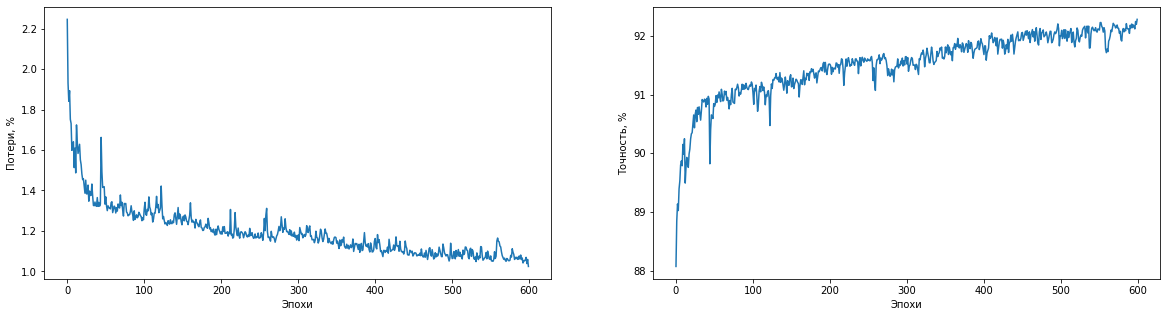

In [ ]:
fig, (losses_ax, metrics_ax) = plt.subplots(1, 2)
fig.set_size_inches(20, 5)

losses_ax.plot([x * 100 for x in history.get('loss')])
losses_ax.set_xlabel('Эпохи')
losses_ax.set_ylabel('Потери, %')

metrics_ax.plot([(1 - x) * 100 for x in history.get('mean_absolute_error')])
metrics_ax.set_xlabel('Эпохи')
metrics_ax.set_ylabel('Точность, %')

In [ ]:
print('Средняя ошибка на тестовых данных (в годах): '
      f'{round(model.evaluate(x_test, y_test, verbose=0)[1] / AGE_NORMALIZER, 1)}')

Средняя ошибка на тестовых данных (в годах): 7.7


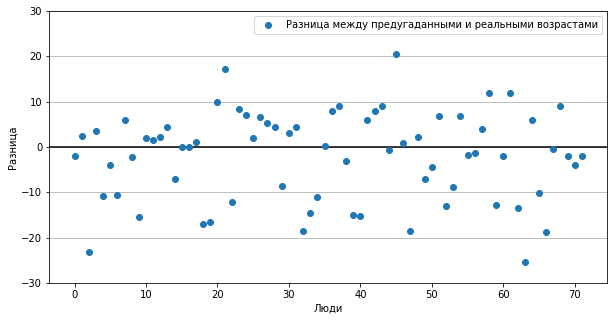

In [429]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10, 5)

predicts = model.predict(x_test)

ax.axhline(0, color='#000')
ax.plot(predicts / AGE_NORMALIZER - y_test / AGE_NORMALIZER, label='Разница между предугаданными и реальными возрастами', linewidth=0, markersize=6, marker='o')

ax.set_xlabel('Люди')
ax.set_ylabel('Разница')
ax.set_yticks(range(-30, 31, 10))
ax.grid(True, axis='y')
ax.legend()

plt.show()

##### Сохранение модели

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!mkdir /content/drive/MyDrive/yandex-lyceum-selection-round
!mkdir /content/drive/MyDrive/yandex-lyceum-selection-round/models

In [ ]:
model.save('/content/drive/MyDrive/yandex-lyceum-selection-round/models/age-model')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/yandex-lyceum-selection-round/models/age-model/assets


In [ ]:
model.save('/content/drive/MyDrive/yandex-lyceum-selection-round/models/age-model.h5')

##### Загрузка модели

In [9]:
from tensorflow.keras.models import load_model
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
model = load_model('/content/drive/MyDrive/yandex-lyceum-selection-round/models/age-model')

##### Вставка возрастов

In [11]:
def age_reformer(row):
    if row.isnull()[age]:
        prepared_row = prepare_data(row.to_frame().transpose())
        age_value = model.predict(np.asarray(prepared_row[X_COLUMNS].to_numpy()).astype('float32'))[0][0]
        row[age] = round(age_value / AGE_NORMALIZER)
    return row

In [12]:
df = df.apply(age_reformer, 1)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   survived     891 non-null    int64  
 1   pclass       891 non-null    int64  
 2   sex          891 non-null    object 
 3   age          891 non-null    float64
 4   sibsp        891 non-null    int64  
 5   parch        891 non-null    int64  
 6   fare         891 non-null    float64
 7   embarked     891 non-null    object 
 8   class        891 non-null    object 
 9   who          891 non-null    object 
 10  adult_male   891 non-null    bool   
 11  deck         203 non-null    object 
 12  embark_town  891 non-null    object 
 13  alive        891 non-null    object 
 14  alone        891 non-null    bool   
dtypes: bool(2), float64(2), int64(4), object(7)
memory usage: 92.4+ KB


##### Решение конфликта `adult_male` и `age`
В датасете присутствует столбец `adult_male`, который был рассчитан автором такой функцией:
```
df["who"] = df[["age", "sex"]].apply(woman_child_or_man, axis=1)
df["adult_male"] = df.who == "man"


def woman_child_or_man(passenger):
    age, sex = passenger
    if age < 16:
        return "child"
    else:
        return dict(male="man", female="woman")[sex]
```
Но так как `np.nan < 16 == False`, то все мужчины, у которых не обозначен возраст, считаются взрослыми. После восстановления возраста можно исправить столбец `adult_male`, помимо этого я хочу в столбце `who` разбить класс `child` на `boy` и `girl`

In [14]:
def who_replace(row): 
    row[who] = (('man', 'woman'), ('boy', 'girl'))[row[age] < 16][row[sex] == 'female']
    return row

In [15]:
df = df.apply(who_replace, 1)
df[adult_male] = df[who] == 'man'

#### Пропуски палубы


In [16]:
def fill_na_deck(data_frame: pd.DataFrame) -> pd.DataFrame:
    data_frame[deck] = data_frame[deck].fillna(u)

    return data_frame

In [17]:
df = fill_na_deck(df)

#### Сохранение заполненной таблицы

In [18]:
!mkdir /content/drive/MyDrive/yandex-lyceum-selection-round/csv

In [19]:
df.to_csv('/content/drive/MyDrive/yandex-lyceum-selection-round/csv/filled_titanic.csv')

#### Загрузка заполненной таблицы

In [21]:
df = pd.read_csv('/content/drive/MyDrive/yandex-lyceum-selection-round/csv/filled_titanic.csv')

## Ответы на вопросы

### a. Кого больше среди пассажиров — мужчин или женщин?

In [23]:
df[who].value_counts()

man      529
woman    262
girl      52
boy       48
Name: who, dtype: int64

| Возраст  | Мужчин | Женщин | 
|----------|:------:|:------:|
| Взрослые |  529   |   262  |
|   Дети   |   48   |    52  | 
|  Всего   |  577   |   314  | 

В целом **мужчин было больше** среди пассажиров , но если смотреть на детей, то в этом случае девочки преобладают, но ответ на вопрос - больше было мужчин.



### b. Каков процент взрослых мужчин от всех пассажиров?

In [24]:
print(f'{round(df[df[adult_male]].shape[0] / df.shape[0] * 100)}% взрослых мужчин')

59% взрослых мужчин


### c. Сколько людей в каждом классе?

In [25]:
df[class_].value_counts()

Third     491
First     216
Second    184
Name: class, dtype: int64

| Класс  | Количество |
|--------|:----------:|
| Первый |     216    |
| Второй |     184    | 
| Третий |     491    | 


## 4. Выводы из результатов

In [26]:
df.describe()

,Unnamed: 0,survived,pclass,age,sibsp,parch,fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,445.000000,0.383838,2.308642,29.067531,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,13.779669,1.102743,0.806057,49.693429
min,0.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,222.500000,0.000000,2.000000,21.000000,0.000000,0.000000,7.910400
50%,445.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,667.500000,1.000000,3.000000,36.000000,1.000000,0.000000,31.000000
max,890.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


#### Средний возраст выживших 

In [27]:
print(f'Средний возраст выживших: {round(df[df[survived] == 1][age].mean())} лет')

Средний возраст выживших: 28 лет


#### Процент выживших по классам
Процент выживших прямо зависит от класса, из чего можно сделать вывод, что безопасность пассажиров также зависит от него. 

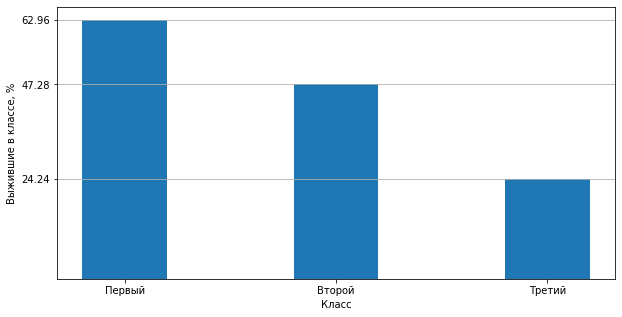

In [428]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 5)

# вычисляет сколько процентов выживших в каждом классе 
# делит, потом сортирует по возрастанию класса 
items = np.array(sorted((
    df[df[survived] == 1][pclass].value_counts() / 
    df[pclass].value_counts() * 100).items(), key=lambda column: column[0]))

ax.bar(items[:, 0], items[:, 1], width=0.4)

ax.set_xticks(items[:, 0])
ax.set_xticklabels(('Первый', 'Второй', 'Третий'))
ax.set_yticks(items[:, 1])
ax.set_ylabel('Выжившие в классе, %')
ax.set_xlabel('Класс')
ax.grid(True, axis='y')

plt.show()

#### Выжившие по цене билета
Как и ожидалось, количество выживших прямо зависит от цены билета: чем больше цена, тем больше относительное количество выживших.

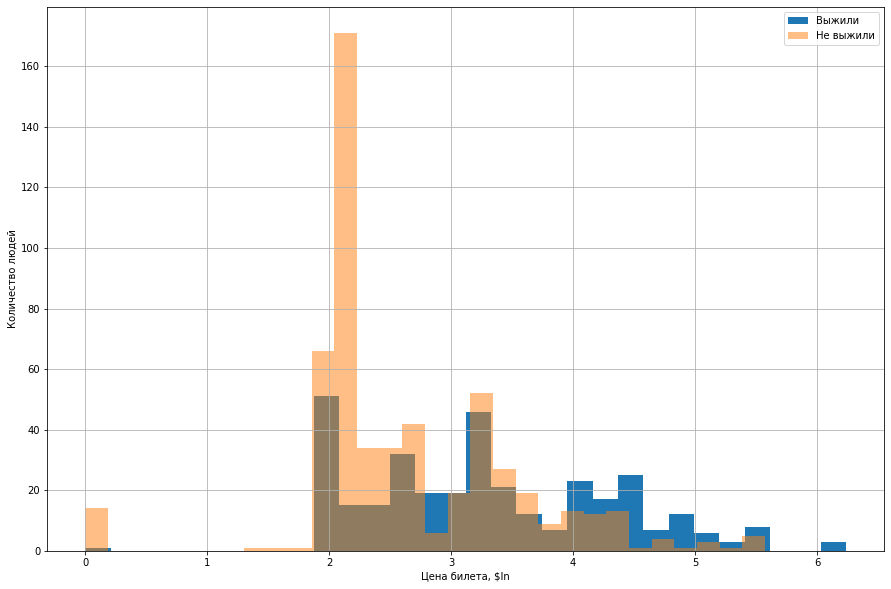

In [235]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
bins = 30

survived_fare = df[df[survived] == 1][fare].apply(np.log).replace(float('-inf'), 0)
survived_fare.hist(
    bins=bins, 
    ax=ax, 
    label='Выжили')

not_survived_fare = df[df[survived] == 0][fare].apply(np.log).replace(float('-inf'), 0)
not_survived_fare.hist(
    bins=bins, 
    ax=ax, 
    label='Не выжили', 
    alpha=0.5)

ax.set_xlabel('Цена билета, $ln')
ax.set_ylabel('Количество людей')
ax.legend()
plt.show()

### Проверка на нормальность

#### Возраст
В данных возраста всех пассажиров присутствует небольшая положительная асимметрия

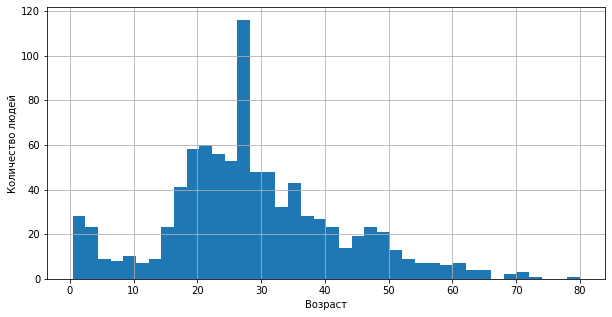

In [ ]:
fig, ax = plt.subplots()
df[age].hist(bins=40, ax=ax)

fig.set_size_inches(10, 5)

ax.set_xlabel('Возраст')
ax.set_ylabel('Количество людей')

plt.show()

Если смотреть на возрасты по классам, то данные распределены нормально только в первом и втором классах, в третьем классе присутствует положительная асимметрия, которая скорее всего и переходит в асимметрию во всей выборке

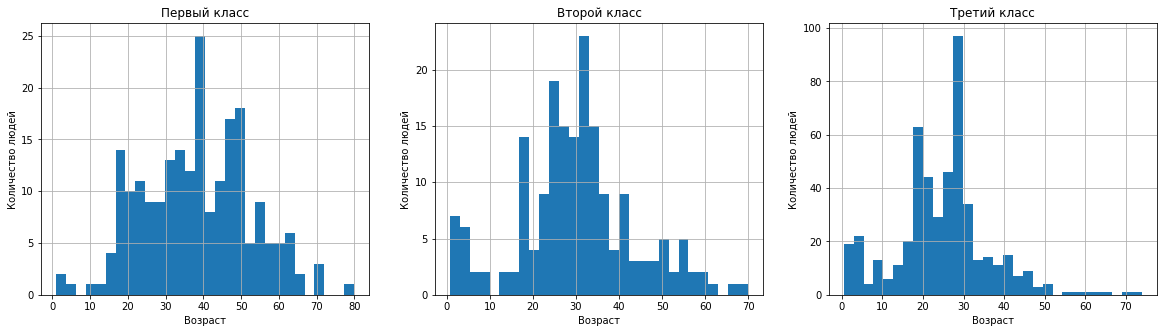

In [237]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

fig.set_size_inches(20, 5)


classes = ('Первый класс', 'Второй класс', 'Третий класс')
for index, ax in enumerate((ax1, ax2, ax3)): 
    ax.set_title(classes[index])
    df[df[pclass] == index + 1][age].hist(bins=30, ax=ax)
    ax.set_xlabel('Возраст')
    ax.set_ylabel('Количество людей')

plt.show()

#### Цена билета
В этом столбце присутствует очень большая положительная асимметрия. 
Я попробовал взять логарифм от значений, чтобы получить логнормальное распределение, это немного исправило ситуацию, но глобально ничего почти не изменилось

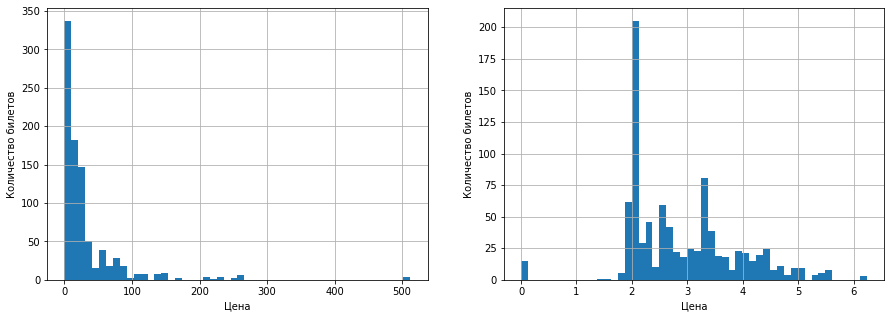

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(15, 5)

df[fare].hist(bins=50, ax=ax1)
ax1.set_xlabel('Цена')
ax1.set_ylabel('Количество билетов')

# Заменяем все значения 
# логарифм от 0 равен -inf, 
# поэтому для построения данной гистограммы пришлось заменять -inf на 0
df[fare].apply(np.log).replace(float('-inf'), 0).hist(bins=50, ax=ax2)
ax2.set_xlabel('Цена')
ax2.set_ylabel('Количество билетов')

plt.show()

### Корреляция между возрастом и ценой билета
Как видно из графиков ниже, корреляции между этими двумя столбцами нет(

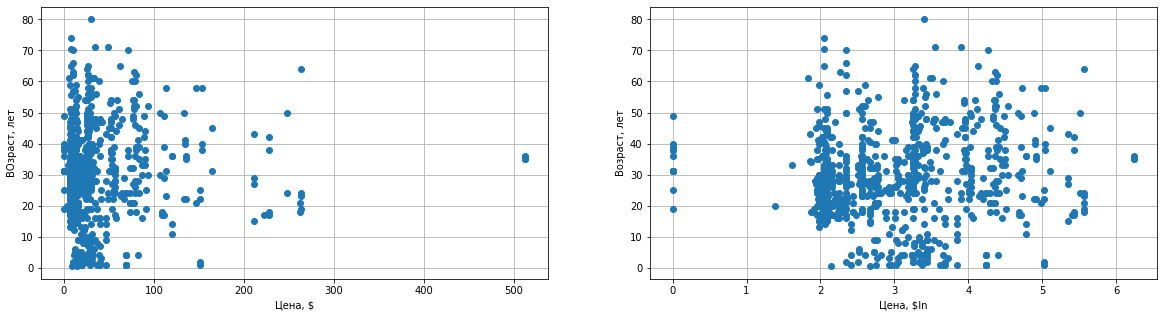

In [242]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(20, 5)

# Корреляция между возрастом и ценой билета
ax1.plot(df[fare], df[age], linewidth=0, marker='o')
ax1.set_xlabel('Цена, $')
ax1.set_ylabel('ВОзраст, лет')
ax1.grid(True)

# корреляция между возрастом и логарифмом цены билеты
ax2.plot(df[fare].apply(np.log).replace(float('-inf'), 0), df[age], linewidth=0, marker='o')
ax2.set_xlabel('Цена, $ln')
ax2.set_ylabel('Возраст, лет')
ax2.grid(True)
plt.show()

## Новая таблица только с выжившими

In [254]:
df_alive = df[df[survived] == 1]
df_alive.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 342 entries, 1 to 889
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   342 non-null    int64  
 1   survived     342 non-null    int64  
 2   pclass       342 non-null    int64  
 3   sex          342 non-null    object 
 4   age          342 non-null    float64
 5   sibsp        342 non-null    int64  
 6   parch        342 non-null    int64  
 7   fare         342 non-null    float64
 8   embarked     342 non-null    object 
 9   class        342 non-null    object 
 10  who          342 non-null    object 
 11  adult_male   342 non-null    bool   
 12  deck         342 non-null    object 
 13  embark_town  342 non-null    object 
 14  alive        342 non-null    object 
 15  alone        342 non-null    bool   
dtypes: bool(2), float64(2), int64(5), object(7)
memory usage: 40.7+ KB


### Изменение в проценте взрослых мужчин и не только
В измененной таблице процент взрослых мужчин резко упал, что подтверждает работу правила "Дамы и дети вперед" уже в те годы. На самом деле больший процент спасенных пал на женщин, за ними - девочки, потом мальчики, заключили же эту последовательность мужчины. Можно сказать, что на борту были настоящие джентльмены.

In [ ]:
print('Выживших взрослых мужчин в изначальной таблице: '
      f'{round(df[df[adult_male] == 1].shape[0] / df.shape[0] * 100)}%')
print('Выживших взрослых мужчин в измененной таблице: '
      f'{round(df_alive[df_alive[adult_male] == 1].shape[0] / df_alive.shape[0] * 100)}%')

Выживших взрослых мужчин в изначальной таблице: 59%
Выживших взрослых мужчин в измененной таблице: 25%


In [ ]:
import matplotlib
matplotlib.__version__

'3.5.1'

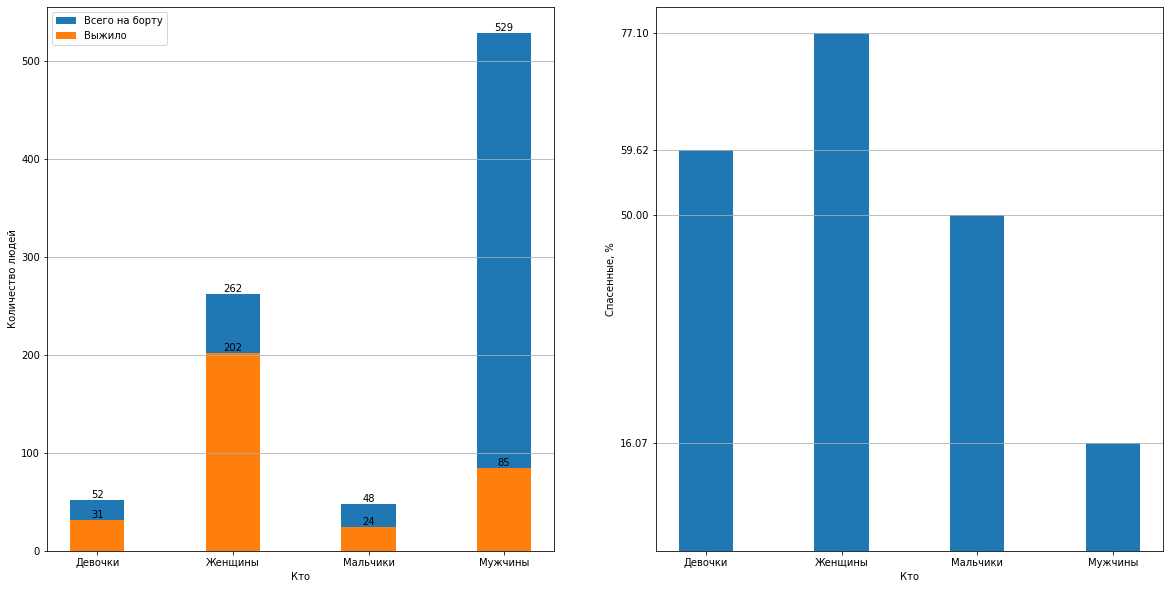

In [427]:
def translate_and_to_numpy(value_counts):
    who_eng_rus_pairs = (('man', 'Мужчины'),
                         ('woman', 'Женщины'),
                         ('girl', 'Девочки'),
                         ('boy', 'Мальчики'))
    return np.array(sorted(
        [(rus, value_counts[eng]) for eng, rus in who_eng_rus_pairs],
        key=lambda x: x[0]
    ))

who_items_all = translate_and_to_numpy(dict(df[who].value_counts()))
who_items_alive = translate_and_to_numpy(dict(df_alive[who].value_counts()))

# строим 
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(20, 10)
for item, label in ((who_items_all, 'Всего на борту'), 
                    (who_items_alive, 'Выжило')): 
    bar = ax1.bar(np.arange(4),  
                item[:, 1].astype(int), 
                width=0.4, 
                label=label)

    ax1.bar_label(bar, labels=item[:, 1])


ax1.set_xlabel('Кто')
ax1.set_ylabel('Количество людей')
ax1.legend()

alive_percentages = (who_items_rus_alive[:, 1].astype(int) / 
                     who_items_rus_all[:, 1].astype(int) * 100)
ax2.bar(np.arange(4), alive_percentages, width=0.4)
ax2.set_yticks(alive_percentages)
ax2.set_xlabel('Кто')
ax2.set_ylabel('Спасенные, %')

for ax in (ax1, ax2): 
    ax.set_xticks(np.arange(4))
    ax.set_xticklabels(who_items_rus_all[:, 0])
    ax.grid(True, axis='y')

plt.show()

### Изменение в соотношении классов
Первый и третий класс поменялись местами, учитывая, что в третьем классе было существенно больше людей, этот факт подтверждает тезис о том, что в первом классе безопасность была куда выше, чем в третьем. Второй класс так и остался на третьем месте в этом рейтинге, но отрыв от лидеров сокращен. 

На результаты большое влияние оказала существенная разница в количестве людей. 


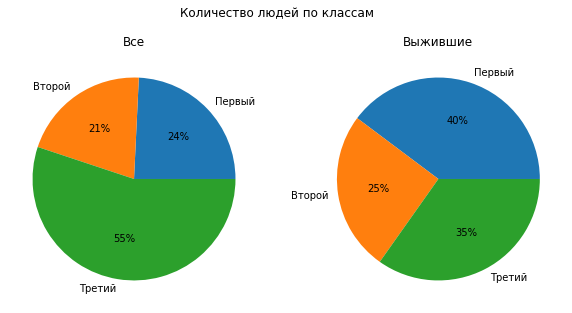

In [343]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(15, 5)

fig.suptitle('Количество людей по классам')
fig.set_size_inches(10, 5)
classes_all = sorted(df[pclass].value_counts().items(), key=lambda x: x[0])
classes_alive = sorted(df_alive[pclass].value_counts().items(), key=lambda x: x[0])

label_texts = {1: 'Первый', 2: 'Второй', 3: 'Третий'}

# [[x, y], [x, y], [x, y]] -> [[x, x, x], [y, y, y]] -> [x, x, x], [y, y, y]
labels_all, x_all = zip(*classes_all)
labels_all = [label_texts[i] for i in labels_all]

labels_alive, x_alive = zip(*classes_alive)
labels_alive = [label_texts[i] for i in labels_alive]

ax1.pie(x_all, labels=labels_all, autopct='%1.0f%%')
ax1.set_title('Все')

ax2.pie(x_alive, labels=labels_alive, autopct='%1.0f%%')
ax2.set_title('Выжившие')

plt.show()

### Изменение соотношений возрастов людей
На удивление мое предположение о том, что люди 20-30 вырвутся вперед по числу спасшихся, не подтвердилось, соотношение возрастов осталось примерно таким же, как и до крушения лайнера.

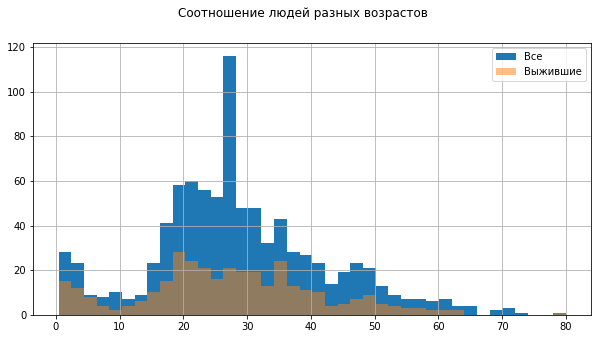

In [358]:
fig, ax = plt.subplots()
fig.suptitle('Соотношение людей разных возрастов')
fig.set_size_inches(10, 5)

bins = 40
df[age].hist(bins=bins, ax=ax, label='Все')
df_alive[age].hist(bins=bins, ax=ax, alpha=0.5, label='Выжившие')

ax.legend()
plt.show()

### Изменение в количестве одиночек
В живых осталось немного меньше одиноких людей, нежели людей, которые отправились в путешествие с семьей, при том, что изначально одиноких людей было на 35% больше.

Сила семьи, какой еще вывод сделать.

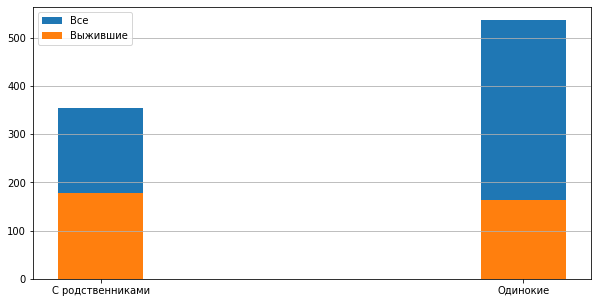

In [426]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 5)

alone_all = np.array(tuple(df[alone].value_counts().items()))
ax.bar(alone_all[:, 0], alone_all[:, 1], width=0.2, label='Все')

alone_alive = np.array(tuple(df_alive[alone].value_counts().items()))
ax.bar(alone_alive[:, 0], alone_alive[:, 1], width=0.2, label='Выжившие')


ax.set_xticks((0, 1))
ax.set_xticklabels(('С родственниками', 'Одинокие'), rotation='horizontal')
ax.legend()
ax.grid(True, axis='y')
plt.show()